In [1]:
# 02_train_model.ipynb - Cell 1
import os, time
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm   # robust tqdm for notebook/console
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())

ROOT = Path("..")
DATA_DIR = ROOT / "data"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Hyperparams (adjust if OOM)
IMAGE_SIZE = 224
BATCH_SIZE = 16           # RTX3050: start 16 (reduce to 8 if OOM)
NUM_EPOCHS = 8
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)




torch: 2.7.1+cu118 cuda: True
Using device: cuda


In [2]:
# Cell 2 — Dataloaders (SAFE + STABLE for Windows + RTX 3050)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Augmentations
train_t = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_t = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Load dataset
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_t)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_t)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_t)

# -------- BEST + MOST STABLE CONFIG --------
NUM_WORKERS = 0        # Windows-safe
PIN_MEMORY = False     # Disable pinned memory for stability
BATCH_SIZE = 16        # Fits into your RTX 3050 4GB VRAM

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

classes = train_ds.classes
num_classes = len(classes)

print("Loaded classes:", num_classes)
print(classes)
print("Dataloaders ready ✔")



Loaded classes: 15
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Dataloaders ready ✔


In [3]:
# Cell 3
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # uses weights enum
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def evaluate_model(net, loader):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            outs = net(imgs)
            preds = torch.argmax(outs, dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    return acc, f1, all_labels, all_preds



In [4]:
# Cell 4 - training with AMP
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()
best_val_acc = 0.0
best_path = MODEL_DIR / "best_model.pth"

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} - train")
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()
        with autocast():
            outs = model(imgs)
            loss = criterion(outs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    val_acc, val_f1, _, _ = evaluate_model(model, val_loader)
    print(f"Epoch {epoch} completed. Train loss: {avg_loss:.4f} | Val acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "classes": classes,
            "epoch": epoch,
            "val_acc": val_acc
        }, best_path)
        print("Saved best model to:", best_path)

print("Training finished. Best val acc:", best_val_acc)



C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 completed. Train loss: 0.3281 | Val acc: 0.9779 | Val F1: 0.9776
Saved best model to: ..\models\best_model.pth


Epoch 2/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 completed. Train loss: 0.1180 | Val acc: 0.9679 | Val F1: 0.9672


Epoch 3/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 completed. Train loss: 0.0894 | Val acc: 0.9895 | Val F1: 0.9894
Saved best model to: ..\models\best_model.pth


Epoch 4/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 completed. Train loss: 0.0762 | Val acc: 0.9916 | Val F1: 0.9917
Saved best model to: ..\models\best_model.pth


Epoch 5/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 completed. Train loss: 0.0578 | Val acc: 0.9953 | Val F1: 0.9953
Saved best model to: ..\models\best_model.pth


Epoch 6/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 completed. Train loss: 0.0565 | Val acc: 0.9926 | Val F1: 0.9926


Epoch 7/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 completed. Train loss: 0.0441 | Val acc: 0.9953 | Val F1: 0.9953


Epoch 8/8 - train:   0%|          | 0/1173 [00:00<?, ?it/s]

C:\Users\Anupr\AppData\Local\Temp\ipykernel_19040\3828083973.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 completed. Train loss: 0.0480 | Val acc: 0.9939 | Val F1: 0.9938
Training finished. Best val acc: 0.9952623267239866


Test Acc: 0.9946 | Test F1: 0.9946


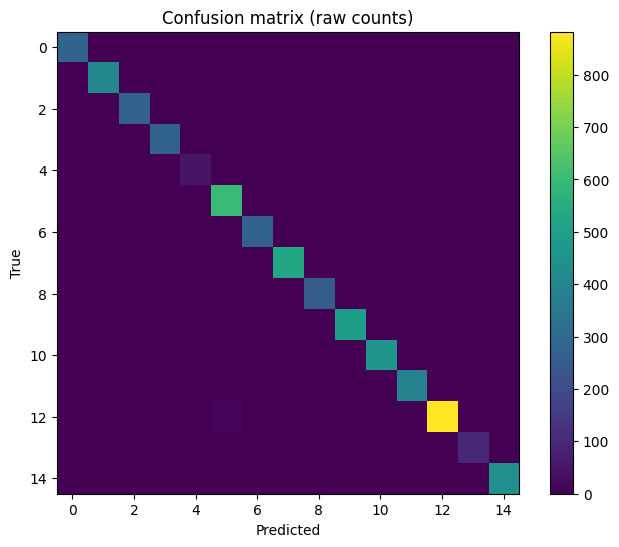

Saved metrics to results/metrics.json


In [5]:
# Cell 5 - final evaluation
import json
from sklearn.metrics import confusion_matrix
ckpt = torch.load(MODEL_DIR / "best_model.pth", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()
test_acc, test_f1, y_true, y_pred = evaluate_model(model, test_loader)
print(f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix (raw counts)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
(Path("..") / "results" / "metrics.json").write_text(json.dumps(report, indent=2))
print("Saved metrics to results/metrics.json")
